# Import Necessary Libraries

In [316]:
import pandas as pd
import gzip
import shutil
import seaborn as sns
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MaxAbsScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score, mean_squared_error, \
mean_absolute_error, explained_variance_score

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


from keras import models, layers 
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.layers import Dense, Dropout, Convolution1D, MaxPooling1D, Flatten, \
GlobalAveragePooling1D, BatchNormalization, Resizing, Rescaling, RandomFlip, RandomRotation

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Exploratory Data Analysis (EDA)

## Calendar Data - 2022

In [317]:
#Load raw calendar data from file
raw_calendar_data = pd.read_csv('../Data/AirBnB/Asheville/2021/asheville_calendar_2021.csv', compression='gzip')
raw_calendar_data

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,881707,2021-12-15,f,$93.00,$93.00,1,1125
1,910737,2021-12-15,t,$156.00,$156.00,2,1125
2,910737,2021-12-16,t,$156.00,$156.00,2,1125
3,910737,2021-12-17,f,$135.00,$135.00,2,1125
4,910737,2021-12-18,f,$135.00,$135.00,2,1125
...,...,...,...,...,...,...,...
958485,51875440,2022-12-10,t,$807.00,$807.00,5,365
958486,51875440,2022-12-11,t,$718.00,$718.00,5,365
958487,51875440,2022-12-12,t,$706.00,$706.00,5,365
958488,51875440,2022-12-13,t,$696.00,$696.00,5,365


In [318]:
#Check the info / types of data
raw_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958490 entries, 0 to 958489
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   listing_id      958490 non-null  int64 
 1   date            958490 non-null  object
 2   available       958490 non-null  object
 3   price           958319 non-null  object
 4   adjusted_price  958319 non-null  object
 5   minimum_nights  958490 non-null  int64 
 6   maximum_nights  958490 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 51.2+ MB


In [319]:
#Convert date column to date-times type
mod_calendar_data = raw_calendar_data
mod_calendar_data['date'] = pd.to_datetime(raw_calendar_data['date'])

#Confirm the info / types of data
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958490 entries, 0 to 958489
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   listing_id      958490 non-null  int64         
 1   date            958490 non-null  datetime64[ns]
 2   available       958490 non-null  object        
 3   price           958319 non-null  object        
 4   adjusted_price  958319 non-null  object        
 5   minimum_nights  958490 non-null  int64         
 6   maximum_nights  958490 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 51.2+ MB


In [320]:
print(f"Earliest date of data set {raw_calendar_data['date'].min()}")
print(f"Latest date of data set {raw_calendar_data['date'].max()}")

Earliest date of data set 2021-12-15 00:00:00
Latest date of data set 2022-12-17 00:00:00


In [321]:
#Check Values of 'Available column'
mod_calendar_data['available'].value_counts()

t    532541
f    425949
Name: available, dtype: int64

In [322]:
#Replace the false and true values with 0 and 1
mod_calendar_data['available'] = mod_calendar_data['available'].replace(['f', 't'],[0, 1])

#Confirm available are now integers
mod_calendar_data['available'].value_counts()

1    532541
0    425949
Name: available, dtype: int64

In [323]:
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958490 entries, 0 to 958489
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   listing_id      958490 non-null  int64         
 1   date            958490 non-null  datetime64[ns]
 2   available       958490 non-null  int64         
 3   price           958319 non-null  object        
 4   adjusted_price  958319 non-null  object        
 5   minimum_nights  958490 non-null  int64         
 6   maximum_nights  958490 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 51.2+ MB


In [324]:
mod_calendar_data['price'].value_counts()

$125.00      29854
$150.00      24356
$99.00       19492
$95.00       19240
$250.00      16814
             ...  
$1,391.00        1
$1,304.00        1
$1,711.00        1
$2,445.00        1
$1,322.00        1
Name: price, Length: 2100, dtype: int64

In [325]:
mod_calendar_data['price'].isna().sum()

171

In [326]:
mod_calendar_data['adjusted_price'].value_counts()

$125.00      28413
$150.00      24264
$99.00       19561
$95.00       19077
$250.00      16475
             ...  
$1,565.00        1
$1,166.00        1
$1,728.00        1
$1,688.00        1
$1,322.00        1
Name: adjusted_price, Length: 2097, dtype: int64

In [327]:
nan_cols = mod_calendar_data[mod_calendar_data['price'].isna()]
nan_cols['listing_id'].value_counts()

47732580    171
Name: listing_id, dtype: int64

In [328]:
bnb_to_drop = mod_calendar_data[(mod_calendar_data['listing_id'] == 47732580)].index
mod_calendar_data = mod_calendar_data.drop(bnb_to_drop)
mod_calendar_data['price'].isna().sum()

0

In [329]:
mod_calendar_data['price']

0          $93.00
1         $156.00
2         $156.00
3         $135.00
4         $135.00
           ...   
958485    $807.00
958486    $718.00
958487    $706.00
958488    $696.00
958489    $687.00
Name: price, Length: 958125, dtype: object

In [330]:
test_price_df = mod_calendar_data['price'].str.split(".", expand=True)
test_price_df = test_price_df.rename(columns = {0 : 'daily_price'})
test_price_df = test_price_df.drop(labels = [1], axis = 1)
mod_calendar_data = test_price_df.join(mod_calendar_data, how = 'left')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace('$', '')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace(',', '')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].astype({'daily_price':'int'})
mod_calendar_data = mod_calendar_data.drop(labels = ['adjusted_price', 'price'], axis = 1)

id_to_move = mod_calendar_data.pop('listing_id')
mod_calendar_data.insert(0, 'listing_id', id_to_move)
mod_calendar_data

/var/folders/vj/wwng1wrx4433kjdgg3pdcmbc0000gn/T/ipykernel_7764/3964135494.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace('$', '')


,listing_id,daily_price,date,available,minimum_nights,maximum_nights
0,881707,93,2021-12-15,0,1,1125
1,910737,156,2021-12-15,1,2,1125
2,910737,156,2021-12-16,1,2,1125
3,910737,135,2021-12-17,0,2,1125
4,910737,135,2021-12-18,0,2,1125
...,...,...,...,...,...,...
958485,51875440,807,2022-12-10,1,5,365
958486,51875440,718,2022-12-11,1,5,365
958487,51875440,706,2022-12-12,1,5,365
958488,51875440,696,2022-12-13,1,5,365


In [331]:
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958125 entries, 0 to 958489
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   listing_id      958125 non-null  int64         
 1   daily_price     958125 non-null  int64         
 2   date            958125 non-null  datetime64[ns]
 3   available       958125 non-null  int64         
 4   minimum_nights  958125 non-null  int64         
 5   maximum_nights  958125 non-null  int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 83.4 MB


In [332]:
#For purposes of this project/the stakeholder, we will drop the adjusted avail, price, min nights, max nights
mod_calendar_data = mod_calendar_data.drop(['available', 'minimum_nights', 'maximum_nights'],
                                          axis = 1)

In [333]:
#Check all columns are integer types
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958125 entries, 0 to 958489
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   listing_id   958125 non-null  int64         
 1   daily_price  958125 non-null  int64         
 2   date         958125 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 61.5 MB


In [334]:
# mod_calendar_data_id_avail = mod_calendar_data.groupby(['listing_id']).sum()
# mod_calendar_data_id_avail = mod_calendar_data_id_avail.reset_index()
# mod_calendar_data_id_avail = mod_calendar_data_id_avail.drop(['price'], axis = 1)
# mod_calendar_data_id_avail['perc_year_avail'] = mod_calendar_data_id_avail['available'] / 365
# mod_calendar_data_id_avail = mod_calendar_data_id_avail.drop(['available'], axis = 1)
# mod_calendar_data_id_avail

In [335]:
# mod_calendar_data_id_avail.info()

## Listings Data - 2022

In [336]:
raw_listings_data = pd.read_csv('../Data/AirBnB/Asheville/2021/asheville_listings_2021.csv')
raw_listings_data.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,108061,https://www.airbnb.com/rooms/108061,20211215062309,2021-12-15,Walk to stores/parks/downtown. Fenced yard/Pet...,Walk to town in ten minutes! Monthly rental in...,"I love my neighborhood! Its friendly, easy-goi...",https://a0.muscache.com/pictures/41011975/0cdf...,320564,https://www.airbnb.com/users/show/320564,...,4.79,4.84,4.48,NaN,f,2,2,0,0,0.71
1,155305,https://www.airbnb.com/rooms/155305,20211215062309,2021-12-15,Cottage! BonPaul + Sharky's Hostel,<b>The space</b><br />Private cottage located ...,"We are within easy walk of pubs, breweries, mu...",https://a0.muscache.com/pictures/8880711/cf38d...,746673,https://www.airbnb.com/users/show/746673,...,4.76,4.93,4.53,NaN,t,7,1,2,4,2.75
2,156805,https://www.airbnb.com/rooms/156805,20211215062309,2021-12-15,"Private Room ""Ader"" at BPS Hostel",<b>The space</b><br />Private Rooms at Bon Pau...,"Easy walk to pubs, cafes, bakery, breweries, l...",https://a0.muscache.com/pictures/23447d55-fa7e...,746673,https://www.airbnb.com/users/show/746673,...,4.61,4.84,4.46,NaN,t,7,1,2,4,0.54
3,156926,https://www.airbnb.com/rooms/156926,20211215062309,2021-12-15,"Mixed Dorm ""Top Bunk #1"" at BPS Hostel",This is a top bunk in the mixed dorm room<br /...,NaN,https://a0.muscache.com/pictures/98f4e655-c4d6...,746673,https://www.airbnb.com/users/show/746673,...,4.80,4.78,4.78,NaN,t,7,1,2,4,2.36
4,160594,https://www.airbnb.com/rooms/160594,20211215062309,2021-12-15,Historic Grove Park,Come enjoy the beautiful Grove Park neighborho...,NaN,https://a0.muscache.com/pictures/92433837/d340...,769252,https://www.airbnb.com/users/show/769252,...,4.88,4.90,4.85,NaN,f,1,0,1,0,0.46


In [337]:
raw_listings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2626 entries, 0 to 2625
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            2626 non-null   int64  
 1   listing_url                                   2626 non-null   object 
 2   scrape_id                                     2626 non-null   int64  
 3   last_scraped                                  2626 non-null   object 
 4   name                                          2626 non-null   object 
 5   description                                   2621 non-null   object 
 6   neighborhood_overview                         2040 non-null   object 
 7   picture_url                                   2626 non-null   object 
 8   host_id                                       2626 non-null   int64  
 9   host_url                                      2626 non-null   o

In [338]:
#Remove irrelevant review columns
mod_listing_data = raw_listings_data.drop(labels = ['review_scores_accuracy', 
                                                    'review_scores_cleanliness', 
                                                    'review_scores_checkin', 
                                                    'review_scores_communication', 
                                                    'review_scores_location',
                                                    'calendar_updated', 
                                                    'license'], axis = 1)

In [339]:
#Remove irrelevant host columns
mod_listing_data = mod_listing_data.drop(labels = ['host_name', 
                                                   'host_since', 
                                                   'host_location', 
                                                   'host_about', 
                                                   'host_response_time', 
                                                   'host_acceptance_rate',
                                                   'host_thumbnail_url', 
                                                   'host_picture_url', 
                                                   'host_neighbourhood', 
                                                   'host_listings_count', 
                                                   'host_total_listings_count', 
                                                   'host_verifications', 
                                                   'host_has_profile_pic',
                                                   'first_review',
                                                   'last_review'], axis = 1)

In [340]:
#Remove

mod_listing_data = mod_listing_data.drop(labels = ['scrape_id',
                                                  'last_scraped',
                                                  'neighbourhood_cleansed',
                                                  'neighbourhood_group_cleansed',
                                                  'property_type',
                                                  'bathrooms',
                                                  'price',
                                                   'minimum_minimum_nights',
                                                   'maximum_minimum_nights',
                                                   'minimum_maximum_nights',
                                                   'maximum_maximum_nights',
                                                   'minimum_nights_avg_ntm',
                                                   'maximum_nights_avg_ntm',
                                                   'has_availability',
                                                   'availability_30',
                                                   'availability_60',
                                                   'availability_90',
                                                   'availability_365',
                                                   'calendar_last_scraped',
                                                   'number_of_reviews_ltm',
                                                   'number_of_reviews_l30d',
                                                   'calculated_host_listings_count',
                                                   'calculated_host_listings_count_entire_homes',
                                                   'calculated_host_listings_count_private_rooms',
                                                   'calculated_host_listings_count_shared_rooms',
                                                  'neighborhood_overview',
                                                  'reviews_per_month',
                                                  'review_scores_value',
                                                  'host_response_rate',
                                                  'description'], axis = 1)

In [341]:
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2626 entries, 0 to 2625
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2626 non-null   int64  
 1   listing_url             2626 non-null   object 
 2   name                    2626 non-null   object 
 3   picture_url             2626 non-null   object 
 4   host_id                 2626 non-null   int64  
 5   host_url                2626 non-null   object 
 6   host_is_superhost       2626 non-null   object 
 7   host_identity_verified  2626 non-null   object 
 8   neighbourhood           2041 non-null   object 
 9   latitude                2626 non-null   float64
 10  longitude               2626 non-null   float64
 11  room_type               2626 non-null   object 
 12  accommodates            2626 non-null   int64  
 13  bathrooms_text          2625 non-null   object 
 14  bedrooms                2463 non-null   

In [342]:
#Fill the missing neighborhood data with 'Asheville, North Carolina, United States'
mod_listing_data['neighbourhood'] = mod_listing_data['neighbourhood'].fillna('Asheville, North Carolina, United States')
mod_listing_data['neighbourhood'].isna().sum()

0

In [343]:
test_neighbor_df = mod_listing_data['neighbourhood'].str.split(",", expand=True)
test_neighbor_df = test_neighbor_df.rename(columns = {0 : 'neighborhood'})
test_neighbor_df = test_neighbor_df.drop(labels = [1, 2, 3, 4], axis = 1)
mod_listing_data = mod_listing_data.join(test_neighbor_df, how = 'outer')
mod_listing_data = mod_listing_data.drop(labels = ['neighbourhood'], axis = 1)
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2626 entries, 0 to 2625
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2626 non-null   int64  
 1   listing_url             2626 non-null   object 
 2   name                    2626 non-null   object 
 3   picture_url             2626 non-null   object 
 4   host_id                 2626 non-null   int64  
 5   host_url                2626 non-null   object 
 6   host_is_superhost       2626 non-null   object 
 7   host_identity_verified  2626 non-null   object 
 8   latitude                2626 non-null   float64
 9   longitude               2626 non-null   float64
 10  room_type               2626 non-null   object 
 11  accommodates            2626 non-null   int64  
 12  bathrooms_text          2625 non-null   object 
 13  bedrooms                2463 non-null   float64
 14  beds                    2558 non-null   

In [344]:
mod_listing_data['neighborhood'] = mod_listing_data['neighborhood'].replace(['Ashville'],['Asheville'])

neigh_to_drop = mod_listing_data[(mod_listing_data['neighborhood'] == 'Leicester') | 
                                 (mod_listing_data['neighborhood'] == 'Swannanoa') | 
                                 (mod_listing_data['neighborhood'] == 'Avery Creek') | 
                                 (mod_listing_data['neighborhood'] == 'Fairview') |
                                 (mod_listing_data['neighborhood'] == 'Limestone') |
                                 (mod_listing_data['neighborhood'] == 'Biltmore Forest')].index
mod_listing_data = mod_listing_data.drop(neigh_to_drop)

In [345]:
mod_listing_data['neighborhood'] = mod_listing_data['neighborhood'].replace(['Asheville '], 'Asheville')

In [346]:
mod_listing_data['neighborhood'].value_counts()

Asheville    2323
Arden         131
Woodfin        62
Candler        54
Fletcher       47
Name: neighborhood, dtype: int64

In [347]:
#Remove rows with no bedrooms data
mod_listing_data = mod_listing_data.dropna(subset = ['bedrooms', 
                                                     'beds', 
                                                     'review_scores_rating', 
                                                     'bathrooms_text'], axis = 0)

In [348]:
mod_listing_data.isna().sum()

id                        0
listing_url               0
name                      0
picture_url               0
host_id                   0
host_url                  0
host_is_superhost         0
host_identity_verified    0
latitude                  0
longitude                 0
room_type                 0
accommodates              0
bathrooms_text            0
bedrooms                  0
beds                      0
amenities                 0
minimum_nights            0
maximum_nights            0
number_of_reviews         0
review_scores_rating      0
instant_bookable          0
neighborhood              0
dtype: int64

In [349]:
#Replace the false and true values with 0 and 1
mod_listing_data['host_is_superhost'] = mod_listing_data['host_is_superhost'].replace(['f', 't'],[0, 1])
mod_listing_data['host_is_superhost'].value_counts()

1    1703
0     566
Name: host_is_superhost, dtype: int64

In [350]:
#Replace the false and true values with 0 and 1
mod_listing_data['host_identity_verified'] = mod_listing_data['host_identity_verified'].replace(['f', 't'],[0, 1])
mod_listing_data['host_identity_verified'].value_counts()

1    1798
0     471
Name: host_identity_verified, dtype: int64

In [351]:
#Replace the false and true values with 0 and 1
mod_listing_data['instant_bookable'] = mod_listing_data['instant_bookable'].replace(['f', 't'],[0, 1])
mod_listing_data['instant_bookable'].value_counts()

1    1322
0     947
Name: instant_bookable, dtype: int64

In [352]:
mod_listing_data['neighborhood'].value_counts()

Asheville    2008
Arden         117
Woodfin        54
Candler        47
Fletcher       43
Name: neighborhood, dtype: int64

In [353]:
mod_listing_data['bathrooms_text'].value_counts()

1 bath              1122
2 baths              481
1 private bath       201
3 baths              102
2.5 baths            100
1.5 baths             92
1 shared bath         67
3.5 baths             32
4 baths               26
1.5 shared baths       8
4.5 baths              8
2 shared baths         7
5 baths                7
2.5 shared baths       6
6 baths                4
5.5 baths              3
0 baths                1
7 baths                1
8 baths                1
Name: bathrooms_text, dtype: int64

In [354]:
mod_listing_data['instant_bookable'].value_counts()

1    1322
0     947
Name: instant_bookable, dtype: int64

In [355]:
mod_listing_data['beds'].value_counts()

1.0     779
2.0     685
3.0     374
4.0     196
5.0      99
6.0      69
7.0      27
8.0      14
9.0       9
11.0      6
12.0      4
10.0      3
21.0      2
13.0      1
15.0      1
Name: beds, dtype: int64

In [356]:
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2269 entries, 0 to 2618
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2269 non-null   int64  
 1   listing_url             2269 non-null   object 
 2   name                    2269 non-null   object 
 3   picture_url             2269 non-null   object 
 4   host_id                 2269 non-null   int64  
 5   host_url                2269 non-null   object 
 6   host_is_superhost       2269 non-null   int64  
 7   host_identity_verified  2269 non-null   int64  
 8   latitude                2269 non-null   float64
 9   longitude               2269 non-null   float64
 10  room_type               2269 non-null   object 
 11  accommodates            2269 non-null   int64  
 12  bathrooms_text          2269 non-null   object 
 13  bedrooms                2269 non-null   float64
 14  beds                    2269 non-null   

In [357]:
mod_listing_data['bathrooms_text'].isna().sum()

0

In [358]:
mod_listing_data['bathrooms_text'].value_counts()

1 bath              1122
2 baths              481
1 private bath       201
3 baths              102
2.5 baths            100
1.5 baths             92
1 shared bath         67
3.5 baths             32
4 baths               26
1.5 shared baths       8
4.5 baths              8
2 shared baths         7
5 baths                7
2.5 shared baths       6
6 baths                4
5.5 baths              3
0 baths                1
7 baths                1
8 baths                1
Name: bathrooms_text, dtype: int64

In [359]:
mod_listing_data['bathrooms_text'] = mod_listing_data['bathrooms_text'].replace(['Shared half-bath', 'Half-bath', 
                                                                                'Private half-bath'],
                                                                                 [0.5, 0.5, 0.5])

In [360]:
mod_listing_data['bathrooms_text'].isna().sum()

0

In [361]:
mod_listing_data['bathrooms_text'].value_counts()

1 bath              1122
2 baths              481
1 private bath       201
3 baths              102
2.5 baths            100
1.5 baths             92
1 shared bath         67
3.5 baths             32
4 baths               26
1.5 shared baths       8
4.5 baths              8
2 shared baths         7
5 baths                7
2.5 shared baths       6
6 baths                4
5.5 baths              3
0 baths                1
7 baths                1
8 baths                1
Name: bathrooms_text, dtype: int64

In [362]:
# mod_listing_data['bathrooms_text'] = mod_listing_data['bathrooms_text'].str.split(" ", n = 1, expand = True)

test_df = mod_listing_data['bathrooms_text'].str.split(" ", expand=True)
test_df = test_df.rename(columns = {0 : 'bathrooms'})
test_df = test_df.drop(labels = [1, 2], axis = 1)
mod_listing_data = mod_listing_data.join(test_df, how = 'outer')
mod_listing_data = mod_listing_data.drop(labels = ['bathrooms_text'], axis = 1)
mod_listing_data['bathrooms'] = mod_listing_data['bathrooms'].fillna(0.5)
mod_listing_data['bathrooms'] = pd.to_numeric(mod_listing_data['bathrooms'])
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2269 entries, 0 to 2618
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2269 non-null   int64  
 1   listing_url             2269 non-null   object 
 2   name                    2269 non-null   object 
 3   picture_url             2269 non-null   object 
 4   host_id                 2269 non-null   int64  
 5   host_url                2269 non-null   object 
 6   host_is_superhost       2269 non-null   int64  
 7   host_identity_verified  2269 non-null   int64  
 8   latitude                2269 non-null   float64
 9   longitude               2269 non-null   float64
 10  room_type               2269 non-null   object 
 11  accommodates            2269 non-null   int64  
 12  bedrooms                2269 non-null   float64
 13  beds                    2269 non-null   float64
 14  amenities               2269 non-null   

In [363]:
target_amenities = ['Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating']

In [364]:
def add_amenity_column(amenity_name):
    mod_listing_data[amenity_name] = mod_listing_data['amenities'].str.contains(amenity_name, regex=False)
    mod_listing_data[amenity_name] = mod_listing_data[amenity_name].replace([False, True],[0, 1])

In [365]:
add_amenity_column(target_amenities[0])
add_amenity_column(target_amenities[1])
add_amenity_column(target_amenities[2])
add_amenity_column(target_amenities[3])
add_amenity_column(target_amenities[4])
add_amenity_column(target_amenities[5])
add_amenity_column(target_amenities[6])

In [366]:
mod_listing_data = mod_listing_data.drop(['amenities'], axis = 1)

In [367]:
mod_listing_data['listing_id'] = mod_listing_data['id']
mod_listing_data = mod_listing_data.drop(['id'], axis = 1)
column_to_move = mod_listing_data.pop('listing_id')
mod_listing_data.insert(0, 'listing_id', column_to_move)
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2269 entries, 0 to 2618
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   listing_id              2269 non-null   int64  
 1   listing_url             2269 non-null   object 
 2   name                    2269 non-null   object 
 3   picture_url             2269 non-null   object 
 4   host_id                 2269 non-null   int64  
 5   host_url                2269 non-null   object 
 6   host_is_superhost       2269 non-null   int64  
 7   host_identity_verified  2269 non-null   int64  
 8   latitude                2269 non-null   float64
 9   longitude               2269 non-null   float64
 10  room_type               2269 non-null   object 
 11  accommodates            2269 non-null   int64  
 12  bedrooms                2269 non-null   float64
 13  beds                    2269 non-null   float64
 14  minimum_nights          2269 non-null   

## Combine Calendar Data and Listings Data

In [368]:
mod_calendar_data

,listing_id,daily_price,date
0,881707,93,2021-12-15
1,910737,156,2021-12-15
2,910737,156,2021-12-16
3,910737,135,2021-12-17
4,910737,135,2021-12-18
...,...,...,...
958485,51875440,807,2022-12-10
958486,51875440,718,2022-12-11
958487,51875440,706,2022-12-12
958488,51875440,696,2022-12-13


In [369]:
mod_calendar_data['listing_id']

0           881707
1           910737
2           910737
3           910737
4           910737
            ...   
958485    51875440
958486    51875440
958487    51875440
958488    51875440
958489    51875440
Name: listing_id, Length: 958125, dtype: int64

In [370]:
print(mod_listing_data.columns)
mod_calendar_data.columns

Index(['listing_id', 'listing_url', 'name', 'picture_url', 'host_id',
       'host_url', 'host_is_superhost', 'host_identity_verified', 'latitude',
       'longitude', 'room_type', 'accommodates', 'bedrooms', 'beds',
       'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_rating', 'instant_bookable', 'neighborhood', 'bathrooms',
       'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer',
       'Heating'],
      dtype='object')


Index(['listing_id', 'daily_price', 'date'], dtype='object')

In [371]:
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958125 entries, 0 to 958489
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   listing_id   958125 non-null  int64         
 1   daily_price  958125 non-null  int64         
 2   date         958125 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 61.5 MB


In [372]:
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2269 entries, 0 to 2618
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   listing_id              2269 non-null   int64  
 1   listing_url             2269 non-null   object 
 2   name                    2269 non-null   object 
 3   picture_url             2269 non-null   object 
 4   host_id                 2269 non-null   int64  
 5   host_url                2269 non-null   object 
 6   host_is_superhost       2269 non-null   int64  
 7   host_identity_verified  2269 non-null   int64  
 8   latitude                2269 non-null   float64
 9   longitude               2269 non-null   float64
 10  room_type               2269 non-null   object 
 11  accommodates            2269 non-null   int64  
 12  bedrooms                2269 non-null   float64
 13  beds                    2269 non-null   float64
 14  minimum_nights          2269 non-null   

### Drop Outliers

In [373]:
asheville_data = pd.merge(mod_listing_data, mod_calendar_data, how = 'left', on = 'listing_id')
asheville_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 827821 entries, 0 to 827820
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   listing_id              827821 non-null  int64         
 1   listing_url             827821 non-null  object        
 2   name                    827821 non-null  object        
 3   picture_url             827821 non-null  object        
 4   host_id                 827821 non-null  int64         
 5   host_url                827821 non-null  object        
 6   host_is_superhost       827821 non-null  int64         
 7   host_identity_verified  827821 non-null  int64         
 8   latitude                827821 non-null  float64       
 9   longitude               827821 non-null  float64       
 10  room_type               827821 non-null  object        
 11  accommodates            827821 non-null  int64         
 12  bedrooms                827821

In [374]:
asheville_data = asheville_data.dropna()

In [375]:
asheville_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 827820 entries, 0 to 827820
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   listing_id              827820 non-null  int64         
 1   listing_url             827820 non-null  object        
 2   name                    827820 non-null  object        
 3   picture_url             827820 non-null  object        
 4   host_id                 827820 non-null  int64         
 5   host_url                827820 non-null  object        
 6   host_is_superhost       827820 non-null  int64         
 7   host_identity_verified  827820 non-null  int64         
 8   latitude                827820 non-null  float64       
 9   longitude               827820 non-null  float64       
 10  room_type               827820 non-null  object        
 11  accommodates            827820 non-null  int64         
 12  bedrooms                827820

In [376]:
asheville_data['bathrooms']

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
827816    1.0
827817    1.0
827818    1.0
827819    1.0
827820    1.0
Name: bathrooms, Length: 827820, dtype: float64

In [377]:
asheville_data = asheville_data[asheville_data['bathrooms'] <= 6]
asheville_data = asheville_data[asheville_data['bathrooms'] >= 1]

asheville_data = asheville_data[asheville_data['bedrooms'] <= 6]
asheville_data = asheville_data[asheville_data['beds'] <= 11]
asheville_data = asheville_data[asheville_data['bathrooms'] <= 5]

asheville_data = asheville_data[asheville_data['room_type'] != 'Hotel room']
asheville_data = asheville_data[asheville_data['room_type'] != 'Shared room']

asheville_data = asheville_data[asheville_data['daily_price'] <= 1000]

In [378]:
asheville_data = asheville_data.reset_index()
asheville_data = asheville_data.drop(['index'], axis = 1)

In [379]:
asheville_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811427 entries, 0 to 811426
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   listing_id              811427 non-null  int64         
 1   listing_url             811427 non-null  object        
 2   name                    811427 non-null  object        
 3   picture_url             811427 non-null  object        
 4   host_id                 811427 non-null  int64         
 5   host_url                811427 non-null  object        
 6   host_is_superhost       811427 non-null  int64         
 7   host_identity_verified  811427 non-null  int64         
 8   latitude                811427 non-null  float64       
 9   longitude               811427 non-null  float64       
 10  room_type               811427 non-null  object        
 11  accommodates            811427 non-null  int64         
 12  bedrooms                811427

# Begin Modeling

## Baseline Model - Random Forest

In [380]:
asheville_modeling_data = asheville_data.drop(['listing_id', 'listing_url', 'name', 'picture_url', 'host_id',
                                              'host_url', 'host_identity_verified', 'latitude', 'longitude',
                                              'minimum_nights', 'maximum_nights', 'number_of_reviews',
                                              'instant_bookable', 'review_scores_rating'], axis = 1)
asheville_modeling_data.head()

,host_is_superhost,room_type,accommodates,bedrooms,beds,neighborhood,bathrooms,Air conditioning,Wifi,TV,Kitchen,Washer,Dryer,Heating,daily_price,date
0,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,0,1,1,1,1,120.0,2021-12-15
1,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,0,1,1,1,1,120.0,2021-12-16
2,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,0,1,1,1,1,120.0,2021-12-17
3,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,0,1,1,1,1,120.0,2021-12-18
4,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,0,1,1,1,1,120.0,2021-12-19


In [381]:
asheville_modeling_data['neighborhood'].value_counts()

Asheville    716942
Arden         42421
Woodfin       19710
Candler       17098
Fletcher      15256
Name: neighborhood, dtype: int64

In [382]:
asheville_modeling_data['day_of_week'] = asheville_modeling_data['date'].dt.dayofweek
asheville_modeling_data['month'] = asheville_modeling_data['date'].dt.month
asheville_modeling_data = asheville_modeling_data.drop(['date'], axis = 1)
asheville_modeling_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811427 entries, 0 to 811426
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   host_is_superhost  811427 non-null  int64  
 1   room_type          811427 non-null  object 
 2   accommodates       811427 non-null  int64  
 3   bedrooms           811427 non-null  float64
 4   beds               811427 non-null  float64
 5   neighborhood       811427 non-null  object 
 6   bathrooms          811427 non-null  float64
 7   Air conditioning   811427 non-null  int64  
 8   Wifi               811427 non-null  int64  
 9   TV                 811427 non-null  int64  
 10  Kitchen            811427 non-null  int64  
 11  Washer             811427 non-null  int64  
 12  Dryer              811427 non-null  int64  
 13  Heating            811427 non-null  int64  
 14  daily_price        811427 non-null  float64
 15  day_of_week        811427 non-null  int64  
 16  mo

In [383]:
asheville_modeling_data['room_type'].value_counts()

Entire home/apt    693601
Private room       117826
Name: room_type, dtype: int64

In [384]:
asheville_modeling_data['Heating'].value_counts()

1    688650
0    122777
Name: Heating, dtype: int64

In [385]:
asheville_modeling_data.describe()

,host_is_superhost,accommodates,bedrooms,beds,bathrooms,Air conditioning,Wifi,TV,Kitchen,Washer,Dryer,Heating,daily_price,day_of_week,month
count,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000
mean,0.753548,4.442354,1.839915,2.378948,1.477150,0.868490,0.964566,0.878959,0.774608,0.561788,0.549746,0.848690,191.948523,2.994582,6.520620
std,0.430945,2.596776,1.014856,1.542368,0.713593,0.337958,0.184874,0.326175,0.417840,0.496168,0.497519,0.358351,139.441946,1.998384,3.449343
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,1.000000
25%,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,99.000000,1.000000,4.000000
50%,1.000000,4.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,150.000000,3.000000,7.000000
75%,1.000000,6.000000,2.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,235.000000,5.000000,10.000000
max,1.000000,16.000000,6.000000,11.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1000.000000,6.000000,12.000000


## Baseline Model - Random Forest

In [386]:
import time 

In [387]:
%%time

baseline_X = asheville_modeling_data.drop(['daily_price'], axis = 1)
baseline_y = asheville_modeling_data['daily_price']

baseline_X_train, baseline_X_test, baseline_y_train, baseline_y_test = train_test_split(baseline_X, 
                                                                                        baseline_y, 
                                                                                        test_size = 0.2)

baseline_numeric_cols = ['host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                         'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating']

baseline_nominal_cols = ['neighborhood', 'room_type', 'day_of_week', 'month']

baseline_numeric_pipeline = Pipeline([('scaler', StandardScaler())])

baseline_nominal_pipeline = Pipeline([('ohe', OneHotEncoder(sparse = False))])

ct = ColumnTransformer([('nominalpipe', baseline_nominal_pipeline, baseline_nominal_cols ),
                        ('numpipe', baseline_numeric_pipeline, baseline_numeric_cols)])

baseline_final_pipe = Pipeline([('preprocess', ct),
                                ('model', RandomForestRegressor())])

baseline_results = baseline_final_pipe.fit(baseline_X_train, baseline_y_train)

CPU times: user 2min 26s, sys: 1.11 s, total: 2min 27s
Wall time: 2min 28s


Baseline train accuracy 0.774256706092315
Baseline train MSE 66.26663195707948
Baseline train MAE 36.86613146507277


Baseline test accuracy 0.749769070146302
Baseline test MSE 69.69250137363021
Baseline test MAE 39.21064386370515


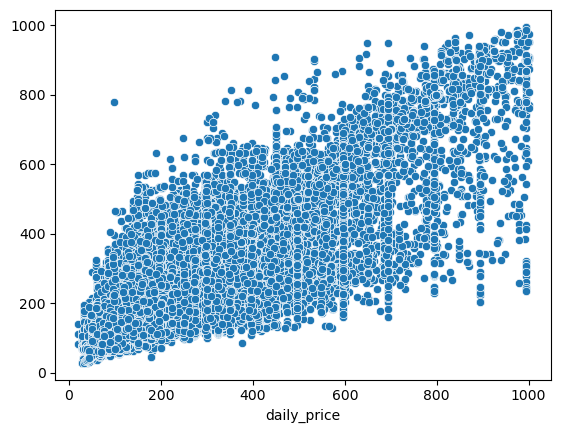

In [388]:
baseline_train_preds = baseline_final_pipe.predict(baseline_X_train)
baseline_test_preds = baseline_final_pipe.predict(baseline_X_test)

print(f'Baseline train accuracy {baseline_final_pipe.score(baseline_X_train, baseline_y_train)}')
print(f'Baseline train MSE {mean_squared_error(baseline_y_train, baseline_train_preds, squared = False)}')
print(f'Baseline train MAE {mean_absolute_error(baseline_y_train, baseline_train_preds)}')
print(f'\n')
print(f'Baseline test accuracy {baseline_final_pipe.score(baseline_X_test, baseline_y_test)}')
print(f'Baseline test MSE {mean_squared_error(baseline_y_test, baseline_test_preds, squared = False)}')
print(f'Baseline test MAE {mean_absolute_error(baseline_y_test, baseline_test_preds)}')

sns.scatterplot(y = baseline_test_preds, x = baseline_y_test);

#ADD MSE AND MAE

In [389]:
baseline_final_pipe['model'].feature_importances_

array([0.00565085, 0.01355105, 0.00296826, 0.00115668, 0.00385725,
       0.01210088, 0.01399074, 0.00127498, 0.00126582, 0.0013111 ,
       0.00188475, 0.01621545, 0.01587282, 0.00202934, 0.0097538 ,
       0.00817228, 0.00396435, 0.00248131, 0.00215417, 0.00198271,
       0.00272817, 0.00155289, 0.00147986, 0.00392792, 0.00294379,
       0.00349261, 0.02990224, 0.11742754, 0.03761645, 0.05400849,
       0.51668963, 0.01794085, 0.00439126, 0.01909575, 0.01170345,
       0.02319559, 0.01727012, 0.01299479])

In [390]:
baseline_final_pipe['preprocess'].get_feature_names_out()

array(['nominalpipe__neighborhood_Arden',
       'nominalpipe__neighborhood_Asheville',
       'nominalpipe__neighborhood_Candler',
       'nominalpipe__neighborhood_Fletcher',
       'nominalpipe__neighborhood_Woodfin',
       'nominalpipe__room_type_Entire home/apt',
       'nominalpipe__room_type_Private room',
       'nominalpipe__day_of_week_0', 'nominalpipe__day_of_week_1',
       'nominalpipe__day_of_week_2', 'nominalpipe__day_of_week_3',
       'nominalpipe__day_of_week_4', 'nominalpipe__day_of_week_5',
       'nominalpipe__day_of_week_6', 'nominalpipe__month_1',
       'nominalpipe__month_2', 'nominalpipe__month_3',
       'nominalpipe__month_4', 'nominalpipe__month_5',
       'nominalpipe__month_6', 'nominalpipe__month_7',
       'nominalpipe__month_8', 'nominalpipe__month_9',
       'nominalpipe__month_10', 'nominalpipe__month_11',
       'nominalpipe__month_12', 'numpipe__host_is_superhost',
       'numpipe__accommodates', 'numpipe__bedrooms', 'numpipe__beds',
       'numpi

In [391]:
baseline_coeffs = dict(zip(baseline_final_pipe['preprocess'].get_feature_names_out(), 
                                 baseline_final_pipe['model'].feature_importances_))
sorted_baseline_coeffs = sorted(baseline_coeffs.items(), key = lambda x:x[1])
sorted_baseline_coeffs

[('nominalpipe__neighborhood_Fletcher', 0.0011566845541375174),
 ('nominalpipe__day_of_week_1', 0.001265817977242282),
 ('nominalpipe__day_of_week_0', 0.001274981411929367),
 ('nominalpipe__day_of_week_2', 0.0013111002634803033),
 ('nominalpipe__month_9', 0.0014798594043528193),
 ('nominalpipe__month_8', 0.0015528933169393494),
 ('nominalpipe__day_of_week_3', 0.0018847508965069149),
 ('nominalpipe__month_6', 0.00198270550572404),
 ('nominalpipe__day_of_week_6', 0.002029335302794257),
 ('nominalpipe__month_5', 0.002154172321609618),
 ('nominalpipe__month_4', 0.0024813074252377004),
 ('nominalpipe__month_7', 0.0027281733239051076),
 ('nominalpipe__month_11', 0.002943790405117647),
 ('nominalpipe__neighborhood_Candler', 0.0029682552003040684),
 ('nominalpipe__month_12', 0.00349261302961317),
 ('nominalpipe__neighborhood_Woodfin', 0.003857248213359854),
 ('nominalpipe__month_10', 0.003927922854118448),
 ('nominalpipe__month_3', 0.003964351861116234),
 ('numpipe__Wifi', 0.004391262855774517

<Figure size 2000x50000 with 0 Axes>

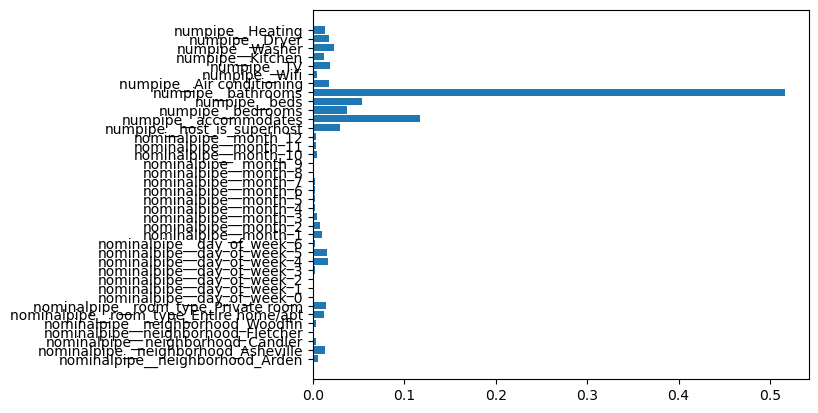

<Figure size 2000x50000 with 0 Axes>

In [392]:
baseline_coeffs_graph = plt.barh(baseline_final_pipe['preprocess'].get_feature_names_out(), 
                                 baseline_final_pipe['model'].feature_importances_)
baseline_coeffs_graph
plt.figure(figsize=(20, 500))

## Model 2 - Neural Network

In [393]:
#Neural Network

In [394]:
#One hot encode the categorical columns
model2_sklearn = asheville_modeling_data
model2_cat = model2_sklearn[['neighborhood', 'room_type', 'day_of_week', 'month']]

ohe = OneHotEncoder(drop="first", sparse=False)
ohe.fit(model2_cat)

model2_cat_ohe = pd.DataFrame(data = ohe.transform(model2_cat),
                              columns = ohe.get_feature_names_out())
model2_cat_ohe

,neighborhood_Asheville,neighborhood_Candler,neighborhood_Fletcher,neighborhood_Woodfin,room_type_Private room,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811422,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
811423,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
811424,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
811425,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [395]:
#Merge the one hot encoded dataframe and the numeric columns
model2_numeric = asheville_modeling_data[['daily_price', 'host_is_superhost', 'accommodates', 'bedrooms', 'beds', 
                                          'bathrooms', 'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 
                                          'Dryer', 'Heating']]

model2_comb_ohe = model2_numeric.join(model2_cat_ohe, how = 'left')
model2_comb_ohe


,daily_price,host_is_superhost,accommodates,bedrooms,beds,bathrooms,Air conditioning,Wifi,TV,Kitchen,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,120.0,0,2,1.0,1.0,1.0,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,120.0,0,2,1.0,1.0,1.0,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,120.0,0,2,1.0,1.0,1.0,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,120.0,0,2,1.0,1.0,1.0,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,120.0,0,2,1.0,1.0,1.0,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811422,165.0,1,3,1.0,1.0,1.0,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
811423,150.0,1,3,1.0,1.0,1.0,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
811424,150.0,1,3,1.0,1.0,1.0,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
811425,150.0,1,3,1.0,1.0,1.0,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [396]:
model2_X = model2_comb_ohe.drop(['daily_price'], axis = 1)
model2_y = model2_comb_ohe['daily_price']

model2_X_train, model2_X_test, model2_y_train, model2_y_test = train_test_split(model2_X, 
                                                                                model2_y, 
                                                                                test_size = 0.18)

model2_X_train, model2_X_val, model2_y_train, model2_y_val = train_test_split(model2_X_train, 
                                                                              model2_y_train,
                                                                              test_size = 0.12)

#### Instantiate a new scaler
scaler = StandardScaler()

model2_X_train_scaled = scaler.fit_transform(model2_X_train)
model2_X_test_scaled = scaler.transform(model2_X_test)
model2_X_val_scaled = scaler.transform(model2_X_val)

In [397]:
#Consider adding a decaying learning rate

In [398]:
#Instantiate a Regularizer

reg = l2(3e-3)

model2_nn = models.Sequential()
model2_nn.add(layers.Flatten())
model2_nn.add(layers.Dense(16, activation = 'relu', input_shape=(34, 1), kernel_regularizer = reg))
model2_nn.add(layers.Dropout(0.5))
model2_nn.add(layers.Dense(1))


#Create an opt variable which is set to the learning rate to be used, we will use 0.0002
opt = Adam(learning_rate = 0.0001)

#Add an early stopping mechanism which will stop fitting the model based on the minimum validation loss, a minimum
    #delta of 0.05, and a patience of 10
es = EarlyStopping(monitor = 'mae', mode = 'min', min_delta = 0.05, patience = 10)

#Set the random seed to 42 for reproducibility
np.random.seed(42)

#Compile the model and utilize the 'opt' variable, 
model2_nn.compile(optimizer = opt,
                  loss = 'mae',
                  metrics = ['mse', 'mae'])

#Create a new _histoire variable containing the fit model
model2_nn_histoire = model2_nn.fit(model2_X_train_scaled,
                                   model2_y_train.values,
                                   callbacks = [es],
                                   epochs = 50,
                                   batch_size = 1000,
                                   validation_data = (model2_X_val_scaled, model2_y_val.values))

Epoch 1/50
  1/586 [..............................] - ETA: 3:01 - loss: 198.3116 - mse: 60526.1445 - mae: 198.2467

2022-12-20 17:14:24.129147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


586/586 [==============================] - ETA: 0s - loss: 191.6249 - mse: 56218.6211 - mae: 191.5573

2022-12-20 17:14:28.282151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


586/586 [==============================] - 5s 7ms/step - loss: 191.6249 - mse: 56218.6211 - mae: 191.5573 - val_loss: 190.7922 - val_mse: 55705.6836 - val_mae: 190.7199
Epoch 2/50
586/586 [==============================] - 4s 7ms/step - loss: 190.2737 - mse: 55657.5391 - mae: 190.1931 - val_loss: 189.3278 - val_mse: 55104.3086 - val_mae: 189.2371
Epoch 3/50
586/586 [==============================] - 5s 8ms/step - loss: 188.6617 - mse: 54999.7031 - mae: 188.5580 - val_loss: 187.5841 - val_mse: 54399.1211 - val_mae: 187.4660
Epoch 4/50
586/586 [==============================] - 5s 8ms/step - loss: 186.7628 - mse: 54241.6797 - mae: 186.6274 - val_loss: 185.5512 - val_mse: 53591.2656 - val_mae: 185.3970
Epoch 5/50
586/586 [==============================] - 5s 8ms/step - loss: 184.5768 - mse: 53389.4062 - mae: 184.4012 - val_loss: 183.2137 - val_mse: 52682.0469 - val_mae: 183.0150
Epoch 6/50
586/586 [==============================] - 4s 7ms/step - loss: 182.0540 - mse: 52429.3672 - mae: 181

Epoch 47/50
586/586 [==============================] - 4s 7ms/step - loss: 95.7577 - mse: 19077.2227 - mae: 93.8898 - val_loss: 75.0543 - val_mse: 13709.1953 - val_mae: 73.1979
Epoch 48/50
586/586 [==============================] - 4s 7ms/step - loss: 95.5348 - mse: 19040.1660 - mae: 93.6896 - val_loss: 74.8065 - val_mse: 13633.6377 - val_mae: 72.9729
Epoch 49/50
586/586 [==============================] - 4s 7ms/step - loss: 95.1258 - mse: 18866.8105 - mae: 93.3033 - val_loss: 74.5946 - val_mse: 13572.3682 - val_mae: 72.7844
Epoch 50/50
586/586 [==============================] - 4s 7ms/step - loss: 94.8401 - mse: 18795.0039 - mae: 93.0411 - val_loss: 74.3320 - val_mse: 13482.0947 - val_mae: 72.5435


In [399]:
model2_nn_results_train = model2_nn.evaluate(model2_X_train_scaled, model2_y_train.values)
model2_nn_results_test = model2_nn.evaluate(model2_X_test_scaled, model2_y_test.values)

print(f'Model 2 Neural Network Train Results: {model2_nn_results_train}')
print(f'Model 2 Neural Network Test Results: {model2_nn_results_test}')

4565/4565 [==============================] - 22s 5ms/step - loss: 74.4478 - mse: 13604.1006 - mae: 72.6591
Model 2 Neural Network Train Results: [74.52605438232422, 13681.75, 72.73783874511719]
Model 2 Neural Network Test Results: [74.44775390625, 13604.1005859375, 72.65910339355469]


In [400]:
model2_nn.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_41 (Flatten)        (None, 34)                0         
                                                                 
 dense_78 (Dense)            (None, 16)                560       
                                                                 
 dropout_56 (Dropout)        (None, 16)                0         
                                                                 
 dense_79 (Dense)            (None, 1)                 17        
                                                                 
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [401]:
model2_nn_train_preds = model2_nn.predict(model2_X_train_scaled)
model2_nn_test_preds = model2_nn.predict(model2_X_test_scaled)

2022-12-20 17:19:52.925452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


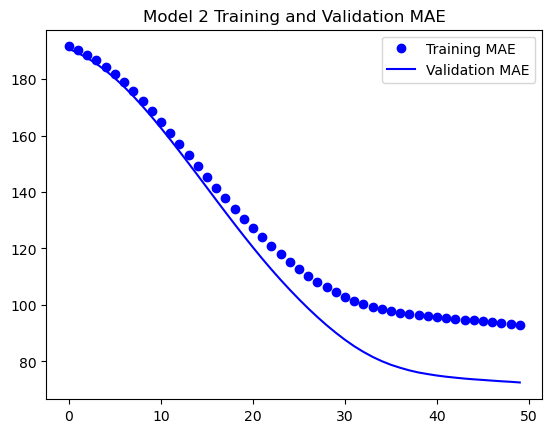

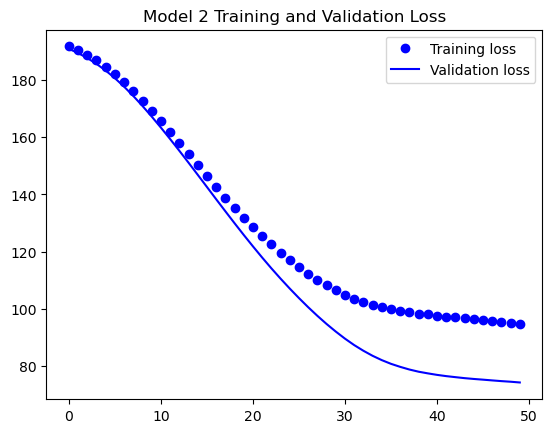

In [402]:
#Plot the model's train MAE, validation MAE, train loss, and validation loss by each epoch using the model's
    #histoire variable
model2_mae = model2_nn_histoire.history['mae']
model2_val_mae = model2_nn_histoire.history['val_mae']
model2_loss = model2_nn_histoire.history['loss']
model2_val_loss = model2_nn_histoire.history['val_loss']
model2_epochs = range(len(model2_mae))

plt.plot(model2_epochs, model2_mae, 'bo', label = 'Training MAE')
plt.plot(model2_epochs, model2_val_mae, 'b', label = 'Validation MAE')
plt.title('Model 2 Training and Validation MAE')
plt.legend()
plt.figure()
plt.plot(model2_epochs, model2_loss, 'bo', label = 'Training loss')
plt.plot(model2_epochs, model2_val_loss, 'b', label = 'Validation loss')
plt.title('Model 2 Training and Validation Loss')
plt.legend()
plt.show();

In [403]:
print(f'Model 2 train MAE w/ preds {mean_absolute_error(model2_y_train.values, model2_nn_train_preds)}')
print(f'Model 2 test MAE w/ preds {mean_absolute_error(model2_y_test.values, model2_nn_test_preds)}')

print(f'Model 2 explained variance train score {explained_variance_score(model2_y_train.values, model2_nn_train_preds)}')
print(f'Model 2 explained variance test score {explained_variance_score(model2_y_test.values, model2_nn_test_preds)}')


print(f'Model 2 test RMSE {mean_squared_error(model2_y_test.values, model2_nn_test_preds, squared = False)}')



Model 2 train MAE w/ preds 72.73746252539644
Model 2 test MAE w/ preds 72.6591830000976
Model 2 explained variance train score 0.4139810231386941
Model 2 explained variance test score 0.41228403550837867
Model 2 test RMSE 116.63659904934079


## Model 3 - Neural Network

In [404]:
#One hot encode the categorical columns
model3_sklearn = asheville_modeling_data
model3_cat = model3_sklearn[['neighborhood', 'room_type', 'day_of_week', 'month']]

ohe = OneHotEncoder(drop = 'first', sparse=False)
ohe.fit(model3_cat)

model3_cat_ohe = pd.DataFrame(data = ohe.transform(model3_cat),
                              columns = ohe.get_feature_names_out())

#Merge the one hot encoded dataframe and the numeric columns
model3_numeric = asheville_modeling_data[['daily_price', 'host_is_superhost', 'accommodates', 'bedrooms', 'beds', 
                                          'bathrooms', 'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 
                                          'Dryer', 'Heating']]

model3_comb_ohe = model2_numeric.join(model2_cat_ohe, how = 'left')

In [405]:
#Begin modeling - set X and y variables
model3_X = model3_comb_ohe.drop(['daily_price'], axis = 1)
model3_y = model3_comb_ohe['daily_price']

model3_X_train, model3_X_test, model3_y_train, model3_y_test = train_test_split(model3_X, 
                                                                                model3_y, 
                                                                                test_size = 0.18)

model3_X_train, model3_X_val, model3_y_train, model3_y_val = train_test_split(model3_X_train, 
                                                                              model3_y_train,
                                                                              test_size = 0.12)

#Instantiate a new scaler
scaler = StandardScaler()

#Scale all columns
model3_X_train_scaled = scaler.fit_transform(model3_X_train)
model3_X_test_scaled = scaler.transform(model3_X_test)
model3_X_val_scaled = scaler.transform(model3_X_val)

In [406]:
#Instantiate a Regularizer
reg = l2(3e-3)

#Begin a new Sequential Model
model3_nn = models.Sequential()
#Consider going bigger to smaller filters between conv1d layers
model3_nn.add(layers.Conv1D(filters = 50, kernel_size = 3, activation = 'relu', padding = 'causal', 
                            input_shape = (model3_X_train_scaled.shape[1], 1)))
model3_nn.add(layers.MaxPooling1D(pool_size = 2))
model3_nn.add(layers.Dropout(0.5))
model3_nn.add(layers.BatchNormalization())
model3_nn.add(layers.Conv1D(filters = 25, kernel_size = 3, activation = 'relu', padding = 'causal', 
                            input_shape = (model3_X_train_scaled.shape[1], 1)))
model3_nn.add(layers.MaxPooling1D(pool_size = 2))
model3_nn.add(layers.BatchNormalization())
model3_nn.add(layers.Dropout(0.4))
model3_nn.add(layers.Flatten())
model3_nn.add(layers.Dense(16, activation = 'relu', input_shape=(34, 1), kernel_regularizer = reg))
model3_nn.add(layers.Dropout(0.3))
model3_nn.add(layers.Dense(8, activation='relu', input_shape=(34, 1), kernel_regularizer = reg))
model3_nn.add(layers.Dense(1))

#Create an opt variable which is set to the learning rate to be used, we will use 0.0002
opt = Adam(learning_rate = 0.0001)

#Add an early stopping mechanism which will stop fitting the model based on the minimum validation loss, a minimum
    #delta of 0.05, and a patience of 10
es = EarlyStopping(monitor = 'mae', mode = 'min', min_delta = 0.05, patience = 10)

#Set the random seed to 42 for reproducibility
np.random.seed(42)

#Compile the model and utilize the 'opt' variable, 
model3_nn.compile(optimizer = opt,
                  loss = 'mae',
                  metrics = ['mse', 'mae'])

#Create a new _histoire variable containing the fit model
model3_nn_histoire = model3_nn.fit(model3_X_train_scaled,
                                   model3_y_train.values,
                                   callbacks = [es],
                                   epochs = 100,
                                   batch_size = 1000,
                                   validation_data = (model3_X_val_scaled, model3_y_val.values))

Epoch 1/100


2022-12-20 17:20:44.295050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


586/586 [==============================] - ETA: 0s - loss: 170.0961 - mse: 49252.2070 - mae: 169.9640

2022-12-20 17:20:57.156526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


586/586 [==============================] - 14s 22ms/step - loss: 170.0961 - mse: 49252.2070 - mae: 169.9640 - val_loss: 124.1032 - val_mse: 34099.4258 - val_mae: 123.9385
Epoch 2/100
586/586 [==============================] - 13s 23ms/step - loss: 94.7309 - mse: 22313.8828 - mae: 94.5334 - val_loss: 75.5458 - val_mse: 15165.3643 - val_mae: 75.3270
Epoch 3/100
586/586 [==============================] - 11s 19ms/step - loss: 82.6768 - mse: 16371.4385 - mae: 82.4491 - val_loss: 71.5244 - val_mse: 13180.4824 - val_mae: 71.2888
Epoch 4/100
586/586 [==============================] - 12s 20ms/step - loss: 79.4306 - mse: 15047.2168 - mae: 79.1896 - val_loss: 69.4352 - val_mse: 12308.0771 - val_mae: 69.1900
Epoch 5/100
586/586 [==============================] - 12s 20ms/step - loss: 77.6783 - mse: 14411.5957 - mae: 77.4314 - val_loss: 68.4055 - val_mse: 11996.7158 - val_mae: 68.1574
Epoch 6/100
586/586 [==============================] - 11s 20ms/step - loss: 76.5182 - mse: 13999.3447 - mae: 76.

586/586 [==============================] - 12s 20ms/step - loss: 68.3989 - mse: 11630.9336 - mae: 68.1344 - val_loss: 64.5164 - val_mse: 10920.5576 - val_mae: 64.2511
Epoch 47/100
586/586 [==============================] - 11s 19ms/step - loss: 68.3558 - mse: 11608.4512 - mae: 68.0905 - val_loss: 64.6239 - val_mse: 11024.5615 - val_mae: 64.3587
Epoch 48/100
586/586 [==============================] - 11s 19ms/step - loss: 68.3221 - mse: 11607.9756 - mae: 68.0563 - val_loss: 64.6597 - val_mse: 11008.5869 - val_mae: 64.3938
Epoch 49/100
586/586 [==============================] - 11s 19ms/step - loss: 68.1864 - mse: 11573.9805 - mae: 67.9200 - val_loss: 64.4839 - val_mse: 10980.0029 - val_mae: 64.2169
Epoch 50/100
586/586 [==============================] - 11s 19ms/step - loss: 68.2170 - mse: 11575.2061 - mae: 67.9500 - val_loss: 64.4619 - val_mse: 10937.0654 - val_mae: 64.1946
Epoch 51/100
586/586 [==============================] - 11s 19ms/step - loss: 68.1662 - mse: 11568.8633 - mae: 67

586/586 [==============================] - 11s 19ms/step - loss: 66.9668 - mse: 11232.7559 - mae: 66.6950 - val_loss: 63.7457 - val_mse: 10760.7314 - val_mae: 63.4741
Epoch 92/100
586/586 [==============================] - 11s 19ms/step - loss: 66.9187 - mse: 11217.0000 - mae: 66.6471 - val_loss: 63.7562 - val_mse: 10761.6455 - val_mae: 63.4847
Epoch 93/100
586/586 [==============================] - 11s 19ms/step - loss: 66.9194 - mse: 11206.9189 - mae: 66.6481 - val_loss: 63.8136 - val_mse: 10815.5273 - val_mae: 63.5424
Epoch 94/100
586/586 [==============================] - 11s 19ms/step - loss: 66.8629 - mse: 11197.3926 - mae: 66.5917 - val_loss: 63.7398 - val_mse: 10803.9326 - val_mae: 63.4688
Epoch 95/100
586/586 [==============================] - 11s 19ms/step - loss: 66.8657 - mse: 11187.4951 - mae: 66.5946 - val_loss: 63.8561 - val_mse: 10847.7070 - val_mae: 63.5853
Epoch 96/100
586/586 [==============================] - 11s 20ms/step - loss: 66.8479 - mse: 11183.3652 - mae: 66

In [407]:
model3_nn_results_train = model3_nn.evaluate(model3_X_train_scaled, model3_y_train.values)
model3_nn_results_test = model3_nn.evaluate(model3_X_test_scaled, model3_y_test.values)

print(f'Model 2 Neural Network Train Results: {model3_nn_results_train}')
print(f'Model 2 Neural Network Test Results: {model3_nn_results_test}')

4565/4565 [==============================] - 30s 7ms/step - loss: 63.8566 - mse: 10833.7148 - mae: 63.5872
Model 2 Neural Network Train Results: [63.890869140625, 10862.0751953125, 63.621498107910156]
Model 2 Neural Network Test Results: [63.8565559387207, 10833.71484375, 63.587223052978516]


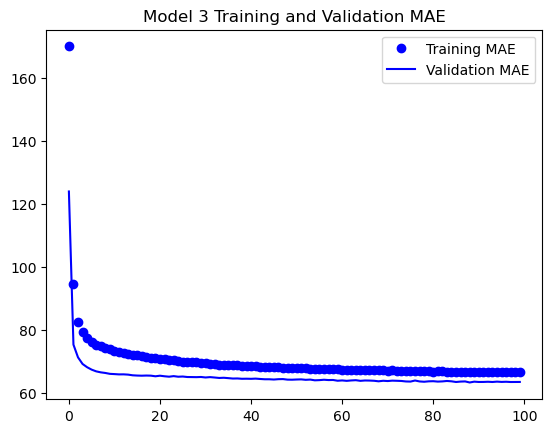

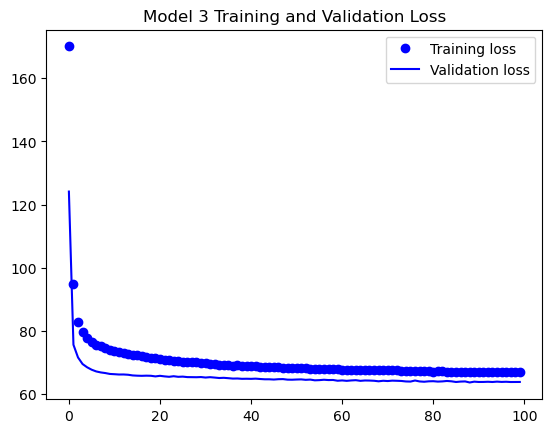

In [408]:
#Plot the model's train MAE, validation MAE, train loss, and validation loss by each epoch using the model's
    #histoire variable
model3_mae = model3_nn_histoire.history['mae']
model3_val_mae = model3_nn_histoire.history['val_mae']
model3_loss = model3_nn_histoire.history['loss']
model3_val_loss = model3_nn_histoire.history['val_loss']
model3_epochs = range(len(model3_mae))

plt.plot(model3_epochs, model3_mae, 'bo', label = 'Training MAE')
plt.plot(model3_epochs, model3_val_mae, 'b', label = 'Validation MAE')
plt.title('Model 3 Training and Validation MAE')
plt.legend()
plt.figure()
plt.plot(model3_epochs, model3_loss, 'bo', label = 'Training loss')
plt.plot(model3_epochs, model3_val_loss, 'b', label = 'Validation loss')
plt.title('Model 3 Training and Validation Loss')
plt.legend()
plt.show();

In [409]:
model3_nn_train_preds = model3_nn.predict(model3_X_train_scaled)
model3_nn_test_preds = model3_nn.predict(model3_X_test_scaled)

2022-12-20 17:42:20.689135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [410]:
print(f'Model 3 train MAE w/ preds {mean_absolute_error(model3_y_train.values, model3_nn_train_preds)}')
print(f'Model 3 test MAE w/ preds {mean_absolute_error(model3_y_test.values, model3_nn_test_preds)}')

print(f'Model 3 explained variance train score {explained_variance_score(model3_y_train.values, model3_nn_train_preds)}')
print(f'Model 3 explained variance test score {explained_variance_score(model3_y_test.values, model3_nn_test_preds)}')


print(f'Model 3 test RMSE {mean_squared_error(model3_y_test.values, model3_nn_test_preds, squared = False)}')

Model 3 train MAE w/ preds 63.6213989571966
Model 3 test MAE w/ preds 63.58722434001476
Model 3 explained variance train score 0.4833122798234001
Model 3 explained variance test score 0.48321155146595196
Model 3 test RMSE 104.08504847082928


In [411]:
#text = input()